In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d mehradaria/leukemia

 82% 91.0M/110M [00:01<00:00, 62.1MB/s]
100% 110M/110M [00:01<00:00, 76.2MB/s] 


In [5]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

In [6]:
import zipfile
zip_ref = zipfile.ZipFile('/content/leukemia.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define hyperparameters
IMG_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 4
NUM_CLASSES = 4

# Define data generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
)

train_generator = train_datagen.flow_from_directory(directory='/content/Original',
                                                    target_size=(IMG_SIZE, IMG_SIZE),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=True)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(directory='/content/drive/MyDrive/Leukemia/test',
                                                target_size=(IMG_SIZE, IMG_SIZE),
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical',
                                                shuffle=False)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(directory='/content/drive/MyDrive/Leukemia/test',
                                                  target_size=(IMG_SIZE, IMG_SIZE),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=False)








Found 3256 images belonging to 4 classes.
Found 876 images belonging to 4 classes.
Found 876 images belonging to 4 classes.


In [8]:
import os

# Define the paths for your datasets
train_dir = '/content/Original'
val_dir = '/content/drive/MyDrive/Leukemia/test'
test_dir = '/content/drive/MyDrive/Leukemia/test'

# Define data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(IMG_SIZE, IMG_SIZE),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=True)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(directory=val_dir,
                                                target_size=(IMG_SIZE, IMG_SIZE),
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical',
                                                shuffle=False)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                  target_size=(IMG_SIZE, IMG_SIZE),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Count the number of original images
num_train_original = sum([len(files) for root, dirs, files in os.walk(train_dir)])
num_val_original = sum([len(files) for root, dirs, files in os.walk(val_dir)])
num_test_original = sum([len(files) for root, dirs, files in os.walk(test_dir)])

# Count the number of augmented images (assuming you have 4 augmentation techniques)
num_train_augmented = len(train_generator) * BATCH_SIZE * 4  # 4 augmentations per original image

# Print the counts
print(f'Number of original training images: {num_train_original}')
print(f'Number of augmented training images: {num_train_augmented}')
print(f'Number of original validation images: {num_val_original}')
print(f'Number of original test images: {num_test_original}')


Found 3256 images belonging to 4 classes.
Found 876 images belonging to 4 classes.
Found 876 images belonging to 4 classes.
Number of original training images: 3256
Number of augmented training images: 13056
Number of original validation images: 876
Number of original test images: 876


In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers

# Load the VGG16 model without the top (fully connected) layers
base_model = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)

# Freeze the weights of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new Sequential model for your custom layers
custom_layers = models.Sequential()

# Add your additional convolutional layers with 'same' padding
custom_layers.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
custom_layers.add(layers.MaxPooling2D((2, 2)))
custom_layers.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
custom_layers.add(layers.MaxPooling2D((2, 2)))
custom_layers.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
custom_layers.add(layers.MaxPooling2D((2, 2)))

# Flatten the output before adding custom layers
custom_layers.add(layers.Flatten())

# Add custom layers
custom_layers.add(layers.Dense(512, activation='relu'))
custom_layers.add(layers.BatchNormalization())
custom_layers.add(layers.Dense(512, activation='relu'))
custom_layers.add(layers.Dropout(0.1))
custom_layers.add(layers.BatchNormalization())
custom_layers.add(layers.Dense(512, activation='relu'))
custom_layers.add(layers.Dropout(0.2))
custom_layers.add(layers.BatchNormalization())

# Output layer with the correct number of units matching your dataset's number of classes
custom_layers.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# Combine the base_model and custom_layers
model = models.Model(inputs=base_model.input, outputs=custom_layers(base_model.output))

# Summary of the entire model
model.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [18]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history=model.fit(train_generator, epochs= 25, validation_data=val_generator)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

Epoch 1/25
102/102 [==============================] - 65s 597ms/step - loss: 0.0351 - accuracy: 0.9902 - val_loss: 3.3802 - val_accuracy: 0.6176
Epoch 2/25
102/102 [==============================] - 63s 611ms/step - loss: 0.0474 - accuracy: 0.9846 - val_loss: 2.6409 - val_accuracy: 0.6632
Epoch 3/25
102/102 [==============================] - 64s 625ms/step - loss: 0.0439 - accuracy: 0.9853 - val_loss: 14.0546 - val_accuracy: 0.2637
Epoch 4/25
102/102 [==============================] - 62s 613ms/step - loss: 0.0335 - accuracy: 0.9883 - val_loss: 0.5158 - val_accuracy: 0.8584
Epoch 5/25
102/102 [==============================] - 64s 623ms/step - loss: 0.0398 - accuracy: 0.9843 - val_loss: 0.2123 - val_accuracy: 0.9292
Epoch 6/25
102/102 [==============================] - 63s 610ms/step - loss: 0.0320 - accuracy: 0.9889 - val_loss: 0.0832 - val_accuracy: 0.9646
Epoch 7/25
102/102 [==============================] - 66s 648ms/step - loss: 0.0255 - accuracy: 0.9908 - val_loss: 0.0265 - val_a

In [19]:
model.save("Leukemiavgg.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 5s 162ms/step


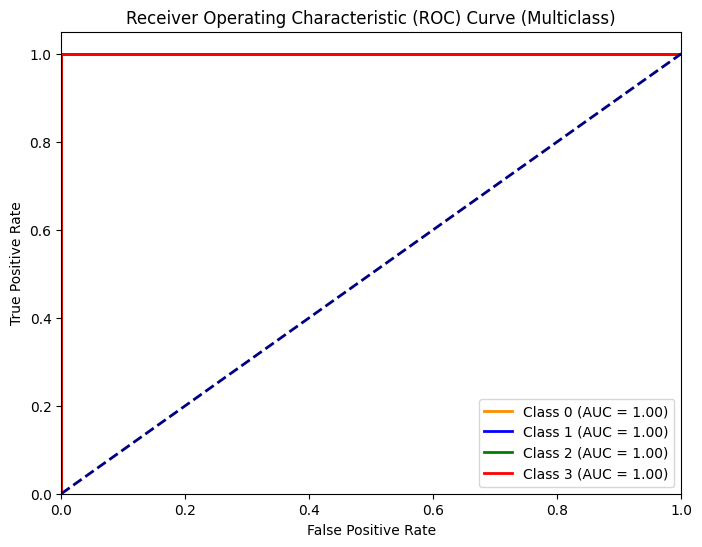

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Get predictions from the model
test_predictions = model.predict(test_generator)

# Convert predictions to class probabilities
test_pred_probs = test_predictions

# Get true labels from the generator
test_true_labels = test_generator.classes

# Binarize the true labels for multiclass ROC curves
n_classes = len(np.unique(test_true_labels))
test_true_labels_bin = label_binarize(test_true_labels, classes=np.arange(n_classes))

# Initialize lists to store ROC curve data for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_true_labels_bin[:, i], test_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
colors = cycle(['darkorange', 'blue', 'green', 'red'])  # Adjust colors as needed

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Multiclass)')
plt.legend(loc='lower right')
plt.show()


28/28 [==============================] - 5s 163ms/step
Confusion matrix, without normalization


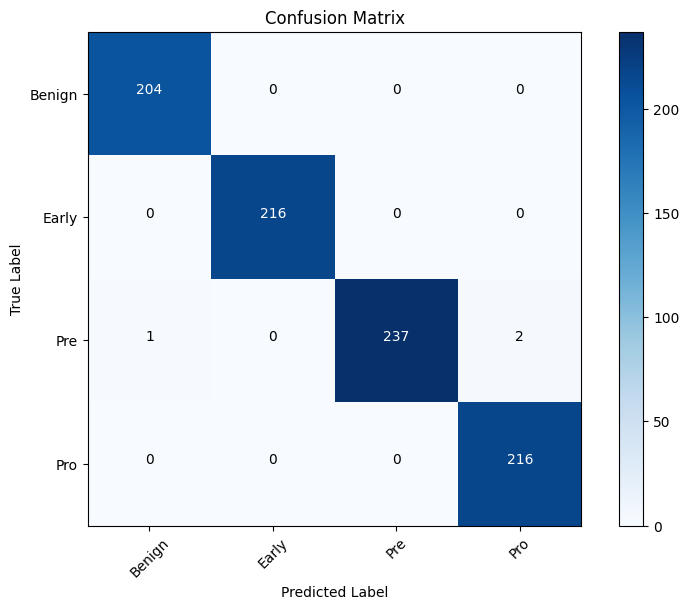

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
import itertools  # Import itertools

# Get predictions from the model
test_predictions = model.predict(test_generator)

# Convert predictions to class labels
test_pred_labels = np.argmax(test_predictions, axis=1)

# Get true labels from the generator
test_true_labels = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Compute confusion matrix
confusion_mat = confusion_matrix(test_true_labels, test_pred_labels)

# Define a function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

# Plot the confusion matrix
plot_confusion_matrix(confusion_mat, classes=class_labels)

plt.show()

28/28 [==============================] - 5s 162ms/step


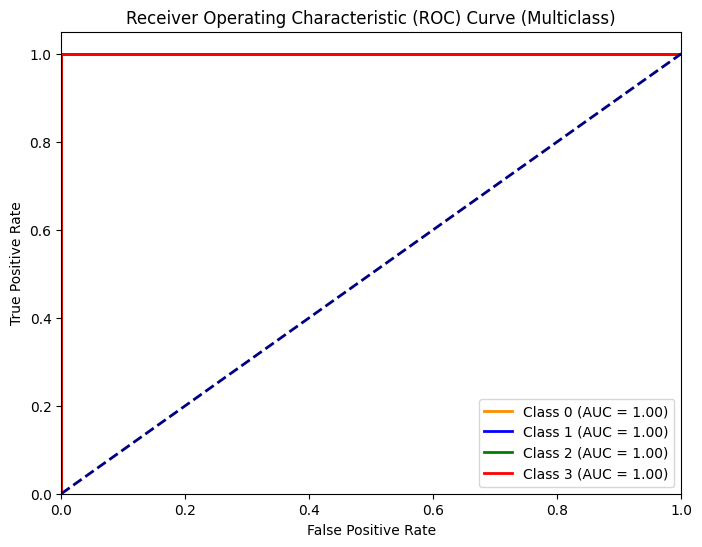

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Get predictions from the model
test_predictions = model.predict(test_generator)

# Convert predictions to class probabilities
test_pred_probs = test_predictions

# Get true labels from the generator
test_true_labels = test_generator.classes

# Binarize the true labels for multiclass ROC curves
n_classes = len(np.unique(test_true_labels))
test_true_labels_bin = label_binarize(test_true_labels, classes=np.arange(n_classes))

# Initialize lists to store ROC curve data for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_true_labels_bin[:, i], test_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
colors = cycle(['darkorange', 'blue', 'green', 'red'])  # Adjust colors as needed

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Multiclass)')
plt.legend(loc='lower right')
plt.show()

In [23]:
from sklearn.metrics import classification_report
import numpy as np

# Get predictions from the model
test_predictions = model.predict(test_generator)

# Convert predictions to class labels
test_pred_labels = np.argmax(test_predictions, axis=1)

# Get true labels from the generator
test_true_labels = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Generate classification report
report = classification_report(test_true_labels, test_pred_labels, target_names=class_labels)
print("Classification Report of Custom CNN Model")

print(report)

28/28 [==============================] - 5s 170ms/step
Classification Report of Custom CNN Model
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       204
       Early       1.00      1.00      1.00       216
         Pre       1.00      0.99      0.99       240
         Pro       0.99      1.00      1.00       216

    accuracy                           1.00       876
   macro avg       1.00      1.00      1.00       876
weighted avg       1.00      1.00      1.00       876



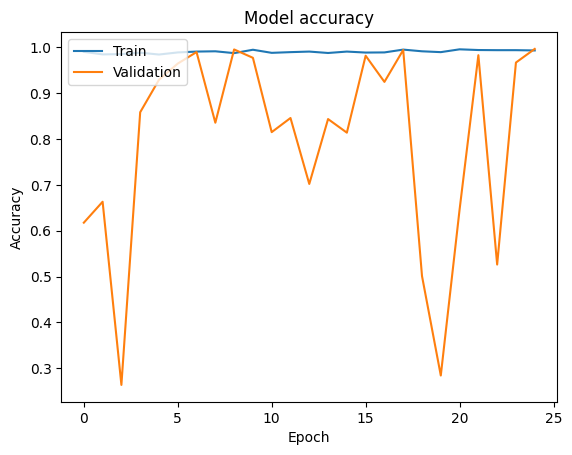

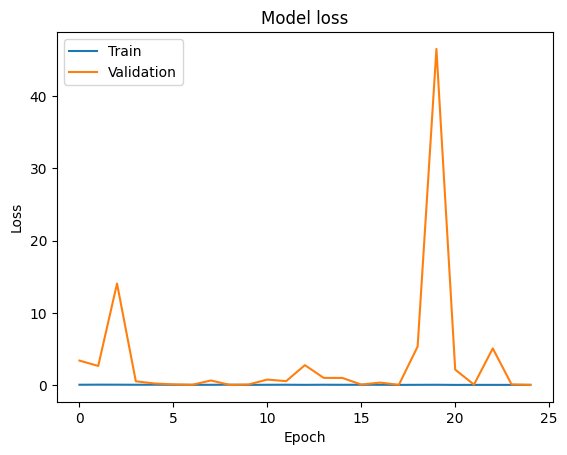

In [24]:

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()